In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fmin
plt.style.use('fivethirtyeight')

# Challenger explosion

In 1986, the Challenger shuttle broke apart and tragically killed seven crew members. This engineering failure spurred a thorough investigation into root cause analysis. Debris was carefully recovered and catalogues by 8 ships and 12 aircrafts over 2 months. 

## O-ring failure

![Cross-sectional diagram of the original SRB field joint. The top end of the lower rocket segment has a deep U-shaped cavity, or clevis, along its circumference. The bottom end of the top segment extends to form a tang that fits snugly into the clevis of the bottom segment. Two parallel grooves near the top of the clevis inner branch hold ~20 foot (6 meter) diameter O-rings that seal the gap between the tang and the clevis, keeping hot gases out.](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/RogersCommission-v1p57_cropped.jpg/220px-RogersCommission-v1p57_cropped.jpg)

The primary cause of failure in this case was the O-ring in the Solid Rocket Booster (SRB) section shown above. The temperature on the day of the launch was $18^oF~(-8^oC)$. This was the coldest temperature of a space shuttle launch, but O-ring data was not conclusive enough to cancel the launch. 

Let's take a deeper look at the O-ring data for the Challenger O-rings. Below, we load the challenger O-ring data into an array where the data is, 

|Flight#|Temp|O-Ring Problem (1 = Fail, 0 = Passed)|
|---| ---|---|
|1 | 53 | 1 |
2|57|1
3|58|1
4|63|1
5|66|0
6|66.8|0
7|67|0
8|67.2|0
9|68|0
10|69|0
11|69.8|1
12|69.8|0
13|70.2|1
14|70.2|0
15|72|0
16|73|0
17|75|0
18|75|1
19|75.8|0
20|76.2|0
21|78|0
22|79|0
23|81|0

In [188]:
oring = np.loadtxt('./challenger_oring.csv', delimiter=',', skiprows= 1)
nring = np.loadtxt('./new_oring.csv', delimiter=',', skiprows= 1)

## Predicting failure

In this data set, we can't draw a histogram or average the data because we only have two possible outcomes: pass or fail. One way to visualize the data is to plot each pass and fail along the temperature axis since we are correlating temperature and failure. 

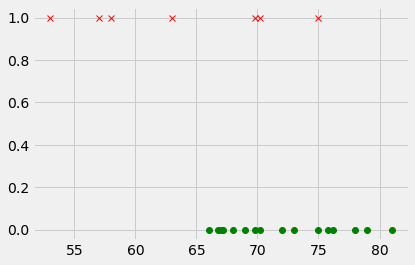

In [189]:
F = oring[:, 2] == 1
P = oring[:, 2] == 0
plt.plot(oring[P, 1], oring[P, 2], 'go')
plt.plot(oring[F, 1], oring[F, 2], 'rx')

The plot above shows that we have some O-rings fail at 70-75F, but many O-rings pass down to 67F. In hindsight, it is seems reasonable to cancel the launch anywhere below 55F because there is demonstrable failure at those temperatures. But, When should you cancel the launch due to unsafe O-ring temperatures? Hotter is better, but there are a number of other systems that have other requirements where timing, personnel, money, and other complicating factors could affect the safety of the mission and its pilots. 



## Case Study: Logistic Regression of Challenger O-rings

The challenger O-ring data is in a common form. The variable we are trying to predict is a binary (or discrete) value, such as pass/fail, broken/not-broken, etc. 

One method to fit this type of data is called [**logistic regression**](https://en.wikipedia.org/wiki/Logistic_regression).

[Logistic Regression link 2](http://www.holehouse.org/mlclass/06_Logistic_Regression.html)

We use a function that varies from 0 to 1 called a logistic function (a.k.a. [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function):

$\sigma(t)=\frac{1}{1+e^{t}}$

We can use this function to describe the likelihood of failure (1) or success (0). When t=0, the probability of failure is 50%. 

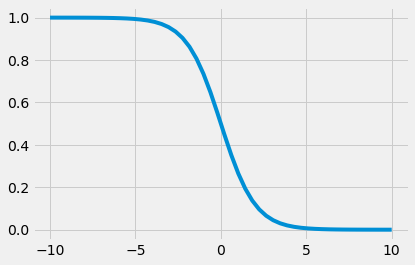

In [190]:
t=np.linspace(-10,10);
sigma= lambda t: 1/(1+np.exp(t));
plt.plot(t,sigma(t))

Now we make the assumption that we can predict the boundary between the pass-fail criteria with a function of our independent variable e.g.

$y=\left\{\begin{array}{cc} 
1 & a_{0}+a_{1}x +\epsilon >0 \\
0 & else \end{array} \right\}$

so the logistic function is now:

$\sigma(x)=\frac{1}{1+e^{-(a_{0}+a_{1}x)}}$

If we choose $a_0~and~a_1$ properly, we should have a smooth function that starts at 1 (Failure) and ends at 0 (Pass) for any temperature, but what values should we use? Try changing `a0` and `a1` below to see what happens, 

_Note: remember we're taking the $\log$ of these values so they are **very** sensitive._

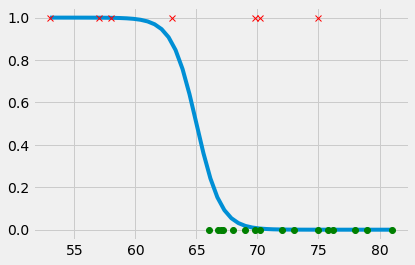

In [191]:
a0 = -65
a1 = 1
T = np.linspace(53, 81)
plt.plot(T, sigma(a0+a1*T))
plt.plot(oring[P, 1], oring[P, 2], 'go')
plt.plot(oring[F, 1], oring[F, 2], 'rx')

The standard method for finding the optimal `a0` and `a1` values is using a cost function: 

$J(a_{0},a_{1})=\sum_{i=1}^{n}\left[-y_{i}\log(\sigma(x_{i}))-(1-y_{i})\log((1-\sigma(x_{i})))\right]$

where $y= 0~or~1$

So if we consider the "cost" of the initial guess above, we have



In [192]:
t = a0 + a1*oring[:, 1];
y = oring[:, 2]
J = 1/len(data)*np.sum(-y*np.log(sigma(t))-(1-y)*np.log(1-sigma(t)))
J

1.9019944388472643

taking this further, we could calculate the cost for a range of `a0` values,

Text(0, 0.5, 'cost, J')

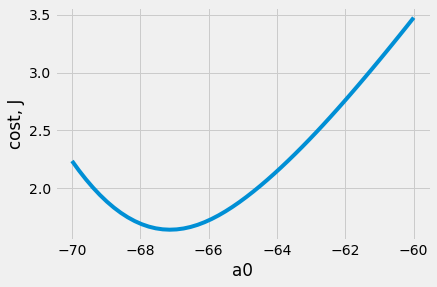

In [193]:
a0lin = np.linspace(-70, -60)
J = np.zeros(len(a0lin))
for i, a0 in enumerate(a0lin):
    t = a0 + a1*oring[:, 1];
    y = oring[:, 2]
    J[i] = 1/len(data)*np.sum(-y*np.log(sigma(t))-(1-y)*np.log(1-sigma(t)))
plt.plot(a0lin, J)
plt.xlabel('a0')
plt.ylabel('cost, J')

The cost will never become 0 because we're trying to predict _probability_ of failure, not pass/fail values e.g. the function varies 0-1 instead of being 0 _or_ 1. 

In [194]:
def cost_logistic(a,x,y):
    '''Create function to calculate cost of logistic function
    t = a0+a1*x
    sigma(t) = 1/(1+e^(t))'''
    
    sigma=lambda t: 1/(1+np.exp(t))
    
    a0 = a[0]
    a1 = a[1]
    
    t = a0+a1*x
    
    J = 1/len(x)*np.sum(-y*np.log(sigma(t))-(1-y)*np.log(1 - sigma(t) + np.finfo(float).eps))
    return J



In [195]:
TF = 0
t = -1
-TF*np.log(sigma(t)) - (1-TF)*np.log(1 - sigma(t)+np.finfo(float).eps)

1.3132616875182221

In [196]:
a=fmin(lambda a: cost_logistic(a,oring[:,1],oring[:,2]),[100,-1])

print(a)

Optimization terminated successfully.
         Current function value: 0.441696
         Iterations: 62
         Function evaluations: 121
[-15.03439342   0.23204062]


(50.0, 85.0, -0.1, 1.2)

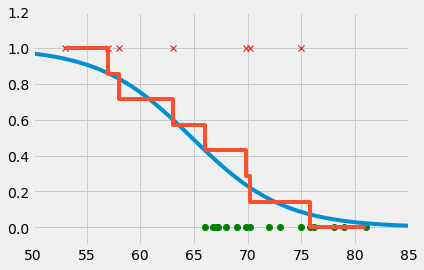

In [197]:
T=np.linspace(50,85);
plt.plot(oring[P, 1], oring[P, 2], 'go')
plt.plot(oring[F, 1], oring[F, 2], 'rx')
plt.plot(T,sigma(a[0]+a[1]*T))
plt.step(oring[::-1, 1], np.cumsum(oring[::-1, 2])/len(oring[F]), )
plt.axis([50,85,-0.1,1.2])

In [198]:
print('probability of failure when 70 degrees is {:1.6} %'.format(100*sigma(a[0]+a[1]*70)))
print('probability of failure when 60 degrees is {:1.6} %'.format(100*sigma(a[0]+a[1]*60)))
print('probability of failure when 18 degrees is {:1.6} %'.format(100*sigma(a[0]+a[1]*18)))


probability of failure when 70 degrees is 22.9975 %
probability of failure when 60 degrees is 75.2494 %
probability of failure when 18 degrees is 99.9981 %


Optimization terminated successfully.
         Current function value: 0.131831
         Iterations: 68
         Function evaluations: 124


array([-41.09923724,   0.56278471])

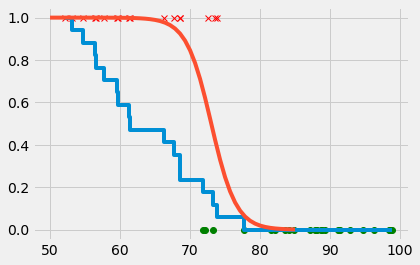

In [199]:
F = nring[:, 2] == 1
P = nring[:, 2] == 0

a=fmin(lambda a: cost_logistic(a,nring[:,1],nring[:,2]),[100,-1])

plt.plot(nring[P, 1], nring[P, 2], 'go')
plt.plot(nring[F, 1], nring[F, 2], 'rx')
plt.step(nring[::-1, 1], np.cumsum(nring[::-1, 2])/len(nring[F]))
plt.plot(T,sigma(a[0]+a[1]*T))
a

In [200]:
print('probability of failure when 80 degrees is {:1.6} %'.format(100*sigma(a[0]+a[1]*80)))
print('probability of failure when 60 degrees is {:1.6} %'.format(100*sigma(a[0]+a[1]*60)))



probability of failure when 80 degrees is 1.93877 %
probability of failure when 60 degrees is 99.9346 %
